# One-Dimensional Climate Models: Brown Dwarfs w/ Disequilibrium Chemistry at Solar M/H and C/O

In this tutorial you will learn how to run 1d climate models with the effects of disequilibrium chemistry as was done for the Elf-OWL Grid [Mukherjee et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240200756M/abstract) (note this should also be cited if using this code/tutorial). 

What you should already be familiar with: 

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to run a basic 1d brown dwarf tutorial](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)


What should have already downloaded: 

1. [Download](https://zenodo.org/record/5590989#.Yzy2YOzMI8a) 1460 PT, 196 wno Correlated-K Tables from Roxana Lupu to be used by the climate code for opacity 
2. [Download](https://zenodo.org/record/5063476/files/structures_m%2B0.0.tar.gz?download=1) the sonora bobcat cloud free `structures_` file so that you can have a simple starting guess 

**NEW:**

3. [Download the .npy](https://doi.org/10.5281/zenodo.10895826) and place them in picaso_refdata folder/climate_INPUTS/661/

> **_NOTE:_**  Tip for getting data from zenodo: pip install zenodo_get then it you can simply retrieve a zenodo posting via the command zenodo_get 10.5281/zenodo.10895826 


### First, check that you have downloaded and placed the correlated-k files in the correct folder

In [1]:
import os;import glob
#
glob.glob(
    os.path.join(os.environ['picaso_refdata'],'climate_INPUTS','661','*npy')
)
#should see a list of files e.g., "/data/reference_data/picaso/reference/climate_INPUTS/661/AlH_1460.npy"

['/data/reference_data/picaso/reference/climate_INPUTS/661/AlH_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/C2H2_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/C2H4_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/C2H6_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/CaH_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/CH4_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/CO_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/CO2_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/CrH_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/Cs_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/Fe_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/FeH_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/H2_1460.npy',
 '/data/reference_data/picaso/reference

In [2]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from astropy import constants as const
from astropy import units as u
import sys
import pandas as pd


## Setting up Initial Run (highlighting main differences for disequilibrium)

In [3]:
mh = '+000' #log metallicity
CtoO = '100'# CtoO ratio relative to solar

ck_db = f'/data/kcoeff_2020_v3/sonora_2020_feh{mh}_co_{CtoO}.data.196'
sonora_profile_db = '/data/sonora_bobcat/structure/structures_m+0.0' #recommended download #2 above

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities


In [4]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation


tint= 700 
grav = 316 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

nlevel = 91 


We recommend starting with Sonora-Bobcat models as an initial guess. 

In [5]:
pressure,temp_guess = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{tint}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)


nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 79 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,89,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is
print(mh,CtoO,tint)


+000 100 700


### Setting K$_{zz}$

We will add one more concept which is the addition of  K$_{zz}$ [cm$^2$/s]. K$_{zz}$ is the eddy diffusion constant, which sets the strength of vertical mixing. In `PICASO` we have two options for  K$_{zz}$: 
 
 1. Constant value: sets a constant at every atmospheric layer
 2. Self consistent (see Eqn. 27 and 28 in [Mukherjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf))


**New code parameters**: 

0. `diseq_chem=True` : Turns on disequilibrium chemistry
1. `self_consistent_kzz` : (True/False) This solves self consistently for 
2. `save_all_kzz` : (True/False) Similar to `save_all_profiles` this saves your intermediate k_zz values if you are trying to solve for a `self_consistent_kzz=True`.
3. `kz` : constant value if `self_consistent_kzz=False`
4. `gases_fly` : **Important**: determines what gases to include in your climate calculation. if you remove one, it will remove the opacity contirubtion from that gas in your climate calculation
5. `chemeq_first` : Converges a chemical equilibrium model first (helpful for convergence)

**Which of those 6 do I need change change**

Likely you will only be changing `kz` and/or, for example, playing around with a `self_consistent_kzz` vs a `constant profile`. Unless you are certain, we recommend the following set of `gases_fly` to remain unchanged. 


In [6]:
#following elf-owl lets use a constant value for all pressures
kzval = pressure*0+1e2

In [7]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                                           nstr = nstr, nofczns = nofczns , rfacv = rfacv, mh =mh, CtoO = CtoO)


gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','PH3','C2H2','Na','K','TiO','VO','FeH']

out = cl_run.climate(opacity_ck, save_all_profiles = True, as_dict=True,with_spec=True,
        save_all_kzz = False, diseq_chem = True, self_consistent_kzz =False, kz = kzval,
        on_fly=True,gases_fly=gases_fly, chemeq_first=False)


1 conv Zone, so making small adjustment
New NSTR status is  [ 0 79 89  0  0  0]


From now I will mix ['CO', 'CH4', 'H2O', 'NH3', 'CO2', 'N2', 'HCN', 'H2', 'PH3', 'C2H2', 'Na', 'K', 'TiO', 'VO', 'FeH'] only on--the--fly


Quench Levels are CO, CO2, NH3, HCN, PH3  [66 59 69 65]
PH3 quenched at level 63
DOING DISEQ CALCULATIONS NOW
PH3 quenched at level 63


Iteration number  0 , min , max temp  228.4687122158246 2719.70009044622 , flux balance  0.02379643790577486
Iteration number  1 , min , max temp  223.4122783881029 2747.845757199295 , flux balance  0.005855307151646336
Iteration number  2 , min , max temp  223.65825853647686 2747.180228403528 , flux balance  6.84958826277869e-05
In t_start: Converged Solution in iterations  2
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 64]


Big iteration is  223.65825853647686 0
Iteration number  0 , min , max temp  221.8104108970629 2747.8007870126216 , flux balance  0.0008430006191004585
Iteration number  1 , min , max temp  221.7834737046501 2747.8026878470228 , flux balance  6.377315081609894e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 64]


Profile converged
 convection zone status
0 79 89 0 0 0
1
[ 0 65 65 65 79 89]
PH3 quenched at level 63


Iteration number  0 , min , max temp  220.5688370747329 2747.671304177 , flux balance  0.00015156615638153807
Iteration number  1 , min , max temp  220.5348149397797 2747.671002662656 , flux balance  1.0509881549915634e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Big iteration is  220.5348149397797 0
Iteration number  0 , min , max temp  220.04904176956381 2747.629626985311 , flux balance  3.781895550711609e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Profile converged
Grow Phase : Upper Zone
[ 0 64 65 65 79 89]
PH3 quenched at level 63


Iteration number  0 , min , max temp  219.32846502328812 2747.479463671103 , flux balance  3.652897700296355e-05
Iteration number  1 , min , max temp  219.30780741192007 2747.4791367912844 , flux balance  3.053127377633008e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Big iteration is  219.30780741192007 0
Iteration number  0 , min , max temp  219.60878373201044 2747.5270235988937 , flux balance  -6.034910814698173e-06
In t_start: Converged Solution in iterations  0
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Profile converged
[ 0 63 65 65 79 89]
PH3 quenched at level 63


Iteration number  0 , min , max temp  219.11327113563087 2747.2727472623956 , flux balance  8.21699017064154e-05
Iteration number  1 , min , max temp  219.0988137695899 2747.27195968955 , flux balance  7.325540033907821e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Big iteration is  219.0988137695899 0
Iteration number  0 , min , max temp  220.04587090507562 2747.385554064864 , flux balance  -2.009781264081523e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Profile converged
[ 0 62 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  223.45168913201945 2747.1200769198817 , flux balance  0.0001655806819819537
Iteration number  1 , min , max temp  223.4359262905261 2747.1189003236373 , flux balance  1.599359355353788e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Big iteration is  223.4359262905261 0
Iteration number  0 , min , max temp  221.29369512319064 2747.2062702571134 , flux balance  1.7480571057486507e-05
 We are already at a root, tolf , test =  5e-05 ,  1.7480571057486507e-05
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Profile converged
[ 0 61 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  223.18079205442217 2746.9016411053 , flux balance  0.00020503249602211074
Iteration number  1 , min , max temp  223.1930504675051 2746.899864788222 , flux balance  2.142786944712075e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Big iteration is  223.1930504675051 0
Iteration number  0 , min , max temp  225.770214612183 2747.0676584044977 , flux balance  -3.744002709368859e-05
Iteration number  1 , min , max temp  225.7772350404269 2747.06741277766 , flux balance  -3.3697582755316545e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 63
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Profile converged
[ 0 60 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  224.37013925105248 2746.7204107395355 , flux balance  0.0002159546232540936
Iteration number  1 , min , max temp  224.32465587815454 2746.718040060723 , flux balance  2.3613265810506326e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Big iteration is  224.32465587815454 0
Iteration number  0 , min , max temp  225.98834504269192 2746.874077043952 , flux balance  -4.0770252207931085e-05


Iteration number  1 , min , max temp  226.0049075554805 2746.873655266751 , flux balance  -4.1944764667596104e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Profile converged
[ 0 59 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  224.3226415573006 2746.5521133531606 , flux balance  0.00022578270738948542
Iteration number  1 , min , max temp  224.2648247997471 2746.5497334773486 , flux balance  2.570488847316762e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Big iteration is  224.2648247997471 0
Iteration number  0 , min , max temp  225.92659941933903 2746.7049506478793 , flux balance  -4.627053394777188e-05
Iteration number  1 , min , max temp  225.94368735176843 2746.704339344802 , flux balance  -5.292445305683144e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Profile converged
[ 0 58 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  224.31081441069972 2746.4194976743975 , flux balance  0.00022065249585450096
Iteration number  1 , min , max temp  224.25667866402722 2746.4171666336233 , flux balance  2.60343798712728e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Big iteration is  224.25667866402722 0
Iteration number  0 , min , max temp  225.97997559075864 2746.5668395225257 , flux balance  -5.307114792858895e-05


Iteration number  1 , min , max temp  225.99741675282547 2746.5660486917527 , flux balance  -6.83427854021894e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 68 65]


Profile converged
[ 0 58 66 66 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  226.66286652412995 2746.0311393002735 , flux balance  6.717700771538913e-05
Iteration number  1 , min , max temp  226.6744885210479 2746.027318676578 , flux balance  3.8148428803394187e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  226.6744885210479 0
Iteration number  0 , min , max temp  227.21659265286513 2746.1567005874203 , flux balance  -2.234854139179267e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 57 66 66 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  225.84278997991666 2745.7583443451485 , flux balance  0.00016296434459140238
Iteration number  1 , min , max temp  225.80434311079225 2745.7526441214627 , flux balance  1.6675972935261093e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  225.80434311079225 0
Iteration number  0 , min , max temp  226.71518305381443 2746.004106574918 , flux balance  -6.802263138035716e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 57 67 67 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  227.84642138094 2745.460803098823 , flux balance  -1.675462244490496e-05
Iteration number  1 , min , max temp  227.86565376922078 2745.454572651484 , flux balance  -1.0015603426265223e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  227.86565376922078 0
Iteration number  0 , min , max temp  228.75213413918863 2745.588987196907 , flux balance  -5.018086032558749e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 56 67 67 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  227.82122303825054 2745.2962772763053 , flux balance  9.393871185462201e-06
Iteration number  1 , min , max temp  227.8099136180094 2745.2852754086935 , flux balance  -1.153148272143708e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  227.8099136180094 0
Iteration number  0 , min , max temp  228.75361934177303 2745.461458508484 , flux balance  -8.686804693931754e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 55 67 67 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  228.26509349517426 2745.2520363954895 , flux balance  -3.7301699972560424e-05
Iteration number  1 , min , max temp  228.26771752069033 2745.2422734845454 , flux balance  -2.158259256021005e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  228.26771752069033 0
Iteration number  0 , min , max temp  229.2039711461108 2745.3890826334714 , flux balance  -8.743704572535724e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 55 68 68 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  230.27148587092253 2745.028702668952 , flux balance  -0.00010347517138005662
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  230.27148587092253 0
Iteration number  0 , min , max temp  230.7385722321025 2745.0997465965156 , flux balance  -3.66166919364084e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 54 68 68 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  230.2272512869794 2744.9746006831774 , flux balance  -0.00018246973948655933
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  230.2272512869794 0
Iteration number  0 , min , max temp  230.83965698490243 2745.0411702919087 , flux balance  -6.524573884867093e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 53 68 68 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  230.7948548523602 2745.009410438036 , flux balance  -0.00012906164134096078
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  230.7948548523602 0
Iteration number  0 , min , max temp  231.1000101462714 2745.0373383791884 , flux balance  -3.536367576979529e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 53 69 69 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  231.2624628780323 2744.9489125751456 , flux balance  1.2258641329597043e-06
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  231.2624628780323 0
Iteration number  0 , min , max temp  231.32057346379273 2745.012585539453 , flux balance  -6.1452341618864596e-06
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
final [ 0 53 69 69 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  231.3470106881548 2744.9590739123046 , flux balance  2.8971108257582678e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  231.3470106881548 0
Iteration number  0 , min , max temp  231.34756672417055 2745.014810047904 , flux balance  1.320085681332785e-06
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
YAY ! ENDING WITH CONVERGENCE
PH3 quenched at level 64


## Compare Diseq and Chemeq Climate Profile 

For the case we chose with very low kzz, and solar M/H the disequilibrium profile and bobcat profiles are identical! 

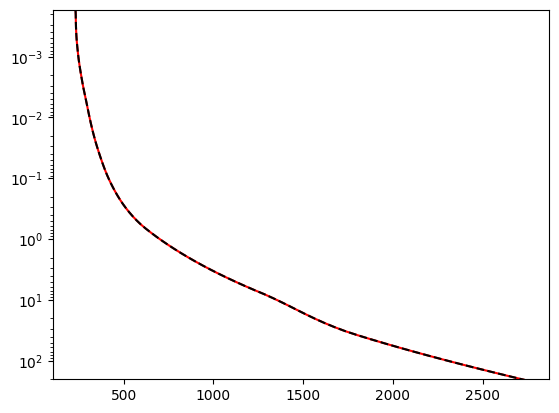

In [8]:
plt.ylim(200,1.7e-4)
plt.semilogy(out['temperature'],out['pressure'],"r", label='Elf-OWL Style, Disequilibrium')
plt.semilogy(temp_guess,pressure,color="k",linestyle="--", label='Bobcat, Chemical Equilibrium')